In [ ]:
!pip install anthropic --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.5/951.5 kB 12.6 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
os.environ['ANTHROPIC_API_KEY'] = userdata.get('ANTHROPIC_API_KEY')

In [ ]:
import pandas as pd
gpt4o_df = pd.read_csv('/content/gpt_4o_mini_full_bench.csv')
gpt4o_df.head()

image_name                                     model_response  \
0  imgs_final_v1/0.jpg  To analyze the image and determine the locatio...   
1  imgs_final_v1/1.jpg  To analyze the image for GeoGuessr, let's brea...   
2  imgs_final_v1/2.jpg  To analyze the image for GeoGuessr, let's brea...   
3  imgs_final_v1/3.jpg  To analyze the image for GeoGuessr, let's brea...   
4  imgs_final_v1/4.jpg  To analyze the image and determine the locatio...   

   label_city label_country   predicted_city predicted_country  label_lat  \
0     Geelong     Australia        Melbourne         Australia -38.148907   
1  Townsville     Australia        Singapore         Singapore -19.249273   
2    Tauranga   New Zealand       Wellington       New Zealand -37.683999   
3      Cairns     Australia           Cairns         Australia -16.919275   
4      Darwin     Australia  Charters Towers         Australia -12.437700   

   label_long  predicted_lat  predicted_long     distance  
0  144.348668       -37.8140       144.96332    65.489556  
1  146.817089         1.3035       103.91150  5210.034546  
2  176.167290       -41.2865       174.77620   417.973338  
3  145.778679       -16.9186       145.77830     0.085147  
4  130.840366       -19.2872       146.15920  1805.442605

In [ ]:
import pandas as pd
categories_df = pd.read_csv('/content/gpt4o_categories.csv')
categories_df.head()

image_name                                     model_response  \
0  imgs_final_v1/0.jpg  To determine the location of this image, let's...   
1  imgs_final_v1/1.jpg  To determine the location depicted in the imag...   
2  imgs_final_v1/2.jpg  To determine the location of this image, let's...   
3  imgs_final_v1/3.jpg  To determine the location depicted in the imag...   
4  imgs_final_v1/4.jpg  To determine the location depicted in the imag...   

      distance  Road and infrastructure  Urban layout and elements  Signage  \
0    65.499125                        1                          1        0   
1  5209.772014                        1                          1        0   
2   417.973338                        1                          1        1   
3     0.097043                        1                          1        1   
4     2.798213                        1                          1        1   

   Architecture  Traffic and vehicles  Vegetation  Environment and climate  \
0             1                     1           1                        1   
1             1                     1           1                        1   
2             1                     1           1                        1   
3             1                     1           1                        1   
4             1                     1           1                        1   

   Lighting and shadows  Recognizable landmarks  Language  \
0                     0                       0         0   
1                     0                       0         0   
2                     0                       0         1   
3                     0                       0         1   
4                     0                       0         1   

   Other cultural elements  Other  \
0                        0      0   
1                        0      0   
2                        0      0   
3                        0      0   
4                        0      0   

                                                 raw  
0  {\n  "Road and infrastructure": 1,\n  "Urban l...  
1  {\n  "Road and infrastructure": 1,\n  "Urban l...  
2  {\n  "Road and infrastructure": 1,\n  "Urban l...  
3  {\n  "Road and infrastructure": 1,\n  "Urban l...  
4  {\n  "Road and infrastructure": 1,\n  "Urban l...

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss
import xgboost as xgb

# 1. Prepare the data
# Assuming categories_df is your dataframe
X = categories_df['model_response']
target_columns = ['Road and infrastructure', 'Urban layout and elements', 'Signage',
                 'Architecture', 'Traffic and vehicles', 'Vegetation',
                 'Environment and climate', 'Lighting and shadows', 'Recognizable landmarks',
                 'Language', 'Other cultural elements', 'Other']
Y = categories_df[target_columns]

# 2. Convert text to TF-IDF features
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf.fit_transform(X)

# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)

# 4. Initialize models (one for each target)
models = {}
predictions = {}

# 5. Train and evaluate for each target
for column in target_columns:
    print(f"\nTraining for: {column}")

    # Handle class imbalance through scale_pos_weight
    pos_scale = np.sum(y_train[column] == 0) / np.sum(y_train[column] == 1)

    # Initialize XGBoost classifier
    model = xgb.XGBClassifier(
        scale_pos_weight=pos_scale,
        learning_rate=0.1,
        max_depth=5,
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    # Train the model
    model.fit(X_train, y_train[column])

    # Make predictions
    predictions[column] = model.predict(X_test)

    # Print metrics
    print(classification_report(y_test[column], predictions[column]))

    # Store the model
    models[column] = model

# 6. Calculate overall metrics
y_pred = pd.DataFrame(predictions)
print("\nOverall Hamming Loss:", hamming_loss(y_test, y_pred))

# 7. Function to make predictions on new text
def predict_categories(text):
    # Transform text using the same TF-IDF vectorizer
    text_tfidf = tfidf.transform([text])

    # Make predictions for each category
    results = {}
    for column in target_columns:
        results[column] = models[column].predict(text_tfidf)[0]

    return results

# Example usage
sample_text = "This is a sample text to test the model"
print("\nPredictions for sample text:")
print(predict_categories(sample_text))


Training for: Road and infrastructure


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.40      0.22      0.29         9
           1       0.98      0.99      0.98       312

    accuracy                           0.97       321
   macro avg       0.69      0.61      0.63       321
weighted avg       0.96      0.97      0.96       321


Training for: Urban layout and elements


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.39      0.70      0.50        10
           1       0.99      0.96      0.98       311

    accuracy                           0.96       321
   macro avg       0.69      0.83      0.74       321
weighted avg       0.97      0.96      0.96       321


Training for: Signage


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.75      0.77      0.76       151
           1       0.79      0.77      0.78       170

    accuracy                           0.77       321
   macro avg       0.77      0.77      0.77       321
weighted avg       0.77      0.77      0.77       321


Training for: Architecture


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.49      0.82      0.61        22
           1       0.99      0.94      0.96       299

    accuracy                           0.93       321
   macro avg       0.74      0.88      0.79       321
weighted avg       0.95      0.93      0.94       321


Training for: Traffic and vehicles


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.61      0.79      0.69       105
           1       0.88      0.75      0.81       216

    accuracy                           0.76       321
   macro avg       0.74      0.77      0.75       321
weighted avg       0.79      0.76      0.77       321


Training for: Vegetation


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.64      0.69      0.67        52
           1       0.94      0.93      0.93       269

    accuracy                           0.89       321
   macro avg       0.79      0.81      0.80       321
weighted avg       0.89      0.89      0.89       321


Training for: Environment and climate


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.56      0.65      0.60        52
           1       0.93      0.90      0.91       269

    accuracy                           0.86       321
   macro avg       0.74      0.78      0.76       321
weighted avg       0.87      0.86      0.86       321


Training for: Lighting and shadows


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.83      0.89      0.86       252
           1       0.47      0.35      0.40        69

    accuracy                           0.78       321
   macro avg       0.65      0.62      0.63       321
weighted avg       0.76      0.78      0.76       321


Training for: Recognizable landmarks


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       302
           1       0.69      0.47      0.56        19

    accuracy                           0.96       321
   macro avg       0.83      0.73      0.77       321
weighted avg       0.95      0.96      0.95       321


Training for: Language


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.79      0.81      0.80       180
           1       0.75      0.73      0.74       141

    accuracy                           0.77       321
   macro avg       0.77      0.77      0.77       321
weighted avg       0.77      0.77      0.77       321


Training for: Other cultural elements


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:48:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       311
           1       0.00      0.00      0.00        10

    accuracy                           0.96       321
   macro avg       0.48      0.49      0.49       321
weighted avg       0.94      0.96      0.95       321


Training for: Other


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:49:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       0.00      0.00      0.00         1

    accuracy                           1.00       321
   macro avg       0.50      0.50      0.50       321
weighted avg       0.99      1.00      1.00       321


Overall Hamming Loss: 0.11708203530633438

Predictions for sample text:
{'Road and infrastructure': 0, 'Urban layout and elements': 0, 'Signage': 0, 'Architecture': 0, 'Traffic and vehicles': 0, 'Vegetation': 0, 'Environment and climate': 0, 'Lighting and shadows': 0, 'Recognizable landmarks': 0, 'Language': 0, 'Other cultural elements': 0, 'Other': 0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def predict_categories(text):
    # Transform text using the same TF-IDF vectorizer
    text_tfidf = tfidf.transform([text])

    # Make predictions for each category
    results = {}
    for column in target_columns:
        results[column] = models[column].predict(text_tfidf)[0]

    return results

# Example usage
sample_text = "building looks cool, there was some vietnamese text on a billboard"
print("\nPredictions for sample text:")
print(predict_categories(sample_text))


Predictions for sample text:
{'Road and infrastructure': 0, 'Urban layout and elements': 0, 'Signage': 0, 'Architecture': 1, 'Traffic and vehicles': 0, 'Vegetation': 0, 'Environment and climate': 0, 'Lighting and shadows': 0, 'Recognizable landmarks': 0, 'Language': 0, 'Other cultural elements': 0, 'Other': 0}


In [ ]:
predict_categories(sample_text).values()

dict_values([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
texts = categories_df['model_response'].values
labels = categories_df[target_columns].values
accuracies = []
for i, text in enumerate(texts):
    print(f"Text {i+1}: {text}")
    print(f"Labels: {labels[i]}")
    prediction = list(predict_categories(text).values())
    print(f"Prediction: {prediction}")
    accuracy = np.mean(prediction == labels[i])
    accuracies.append(accuracy)
    print(f"Accuracy: {accuracy}\n")

Streaming output truncated to the last 5000 lines.
3. **Language and Signs**: Although the text on the tricycle is blurred, the style and format are consistent with those found in the Philippines.

4. **Environment**: The tropical vegetation and the general street layout are typical of urban areas in the Philippines.

5. **Infrastructure**: The presence of overhead power lines and the condition of the road suggest a residential area in a city.

Based on these observations, the most likely location is a residential area in the Philippines. Given the urban setting and the clues, a reasonable guess would be a city like Manila or Cebu.

Here's the best guess for the coordinates:

```json
{
  "lat": 14.5995,
  "long": 120.9842,
  "city": "Manila",
  "country": "Philippines"
}
```
Labels: [1 1 0 1 1 1 1 0 0 0 0 0]
Prediction: [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]
Accuracy: 1.0

Text 1410: To determine the location of this image, let's analyze the visual clues:

1. **Vegetation and Climate**: 

In [ ]:
mean = np.mean(accuracies)
print(f"Mean accuracy: {mean}")

Mean accuracy: 0.966344153141906


In [ ]:
#gpt4omini_df = pd.read_csv('/content/gpt_4o_mini_full_bench.csv')
#gpt4omini_df.head()
gpt4omini_df = pd.read_csv('/content/gemini-1-5-flash-full-bench.csv')


In [ ]:
gpt4o_mini_responses = gpt4omini_df['model_response'].values
road_and_infrastructure = []
urban_layout_and_elements = []
signage = []
architecture = []
traffic_and_vehicles = []
vegetation = []
environment_and_climate = []
lighting_and_shadows = []
recognizable_landmarks = []
language = []
other_cultural_elements = []
other = []

for i, text in enumerate(gpt4o_mini_responses):
    print(f"Text {i+1}: {text}")
    prediction = list(predict_categories(text).values())
    print(f"Prediction: {prediction}")
    road_and_infrastructure.append(prediction[0])
    urban_layout_and_elements.append(prediction[1])
    signage.append(prediction[2])
    architecture.append(prediction[3])
    traffic_and_vehicles.append(prediction[4])
    vegetation.append(prediction[5])
    environment_and_climate.append(prediction[6])
    lighting_and_shadows.append(prediction[7])
    recognizable_landmarks.append(prediction[8])
    language.append(prediction[9])
    other_cultural_elements.append(prediction[10])
    other.append(prediction[11])

new_df = pd.DataFrame({
    'model_response': gpt4o_mini_responses,
    'Road and infrastructure': road_and_infrastructure,
    'Urban layout and elements': urban_layout_and_elements,
    'Signage': signage,
    'Architecture': architecture,
    'Traffic and vehicles': traffic_and_vehicles,
    'Vegetation': vegetation,
    'Environment and climate': environment_and_climate,
    'Lighting and shadows': lighting_and_shadows,
    'Recognizable landmarks': recognizable_landmarks,
    'Language': language,
    'Other cultural elements': other_cultural_elements,
    'Other': other
})


Streaming output truncated to the last 5000 lines.
Text 1264: The image shows a large industrial facility, likely a chemical plant or a storage depot, with several large white tanks in the background. The road leading up to the facility seems to be relatively wide and could be a major highway or a bypass road. The vegetation in the foreground and background hints at a subtropical climate. The clear sky and the overall landscape suggest a location in the southern United States. 

Considering these factors, it is likely that the image was taken in a city with significant industrial activity and a location near a major highway. My best guess for the location is:

{"lat": 29.7586, "long": -95.3616, "city": "Houston", "country": "United States"}

This location is close to the Houston Ship Channel, known for its industrial activity, and is also near a highway with a similar road infrastructure as depicted in the image. 

Prediction: [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
Text 1265: The image f

In [ ]:
new_df.to_csv('gemini-1-5-flash_categories.csv', index=False)

In [ ]:
# prompt: use model's prediction + detecting keywords for each cateogory in the model_response and measure accuracy again

import re

def predict_with_keywords(text, model, keywords):
    # Model prediction
    model_prediction = predict(text, model)

    # Keyword detection
    keyword_matches = [any(re.search(keyword, text, re.IGNORECASE) for keyword in category_keywords) for category_keywords in keywords]

    # Combine model prediction and keyword detection
    combined_prediction = np.where(np.array(keyword_matches), 1, model_prediction)

    return combined_prediction


# Example keywords (expand this list for each category)
keywords = [
    ["road", "infrastructure", "highway", "street", "intersection", "lane", "pavement", "bridge"],  # Road and infrastructure
    ["city", "town", "urban", "building", "block", "layout", "street"],  # Urban layout and elements
    ["sign", "signal", "traffic sign", "stop sign", "signage"],  # Signage
    ["building", "architecture", "house", "structure", "style"],  # Architecture
    ["car", "vehicle", "truck", "traffic", "bus"],  # Traffic and vehicles
    ["tree", "plant", "forest", "vegetation", "park"],  # Vegetation
    ["environment", "weather", "climate", "pollution"],  # Environment and climate
    ["light", "shadow", "illumination"],  # Lighting and shadows
    ["landmark", "monument", "tower", "statue", "famous"],  # Recognizable landmarks
    ["language", "words", "text", "writing", "letters", "characters"],  # Language
    ["culture", "tradition", "art", "history", "clothing", "people", "clothes"],  # Other cultural elements
    ["other"]  # Other
]


# Predict with keywords
all_predictions_with_keywords = []
for i, text in enumerate(texts):
    all_predictions_with_keywords.append(predict_with_keywords(text, model, keywords))

all_predictions_with_keywords = np.array(all_predictions_with_keywords)

# Calculate accuracy for all predictions
accuracy_with_keywords = np.mean(all_predictions_with_keywords == labels)
print(f"Overall Accuracy (with keywords): {accuracy_with_keywords}")


# Calculate accuracy per category
for i, category in enumerate(label_columns):
    category_accuracy = np.mean(all_predictions_with_keywords[:, i] == labels[:, i])
    print(f"Accuracy for {category} (with keywords): {category_accuracy}")

NameError: name 'predict' is not defined

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
from torch import nn

# Convert your labels to binary tensors
label_columns = ['Road and infrastructure', 'Urban layout and elements', 'Signage', 'Architecture', 'Traffic and vehicles', 'Vegetation', 'Environment and climate', 'Lighting and shadows', 'Recognizable landmarks', 'Language', 'Other cultural elements', 'Other']
labels = categories_df[label_columns].values

# Get the text responses
texts = categories_df['model_response'].values

class GeoReasoningClassifier(nn.Module):
    def __init__(self, transformer_model="all-MiniLM-L6-v2"):
        super().__init__()
        self.transformer = SentenceTransformer(transformer_model)
        self.classifier = nn.Linear(384, len(label_columns))  # 384 is embedding size
        self.sigmoid = nn.Sigmoid()

    def forward(self, texts):
        embeddings = self.transformer.encode(texts, convert_to_tensor=True)
        return self.sigmoid(self.classifier(embeddings))

from torch.utils.data import DataLoader, TensorDataset

model = GeoReasoningClassifier()

# Create dataset
embeddings = model.transformer.encode(texts, convert_to_tensor=True)
dataset = TensorDataset(embeddings, torch.FloatTensor(labels))
loader = DataLoader(dataset, batch_size=16)

# Train
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(100):
    for batch_embeddings, batch_labels in loader:
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

def predict(text):
    embedding = model.transformer.encode(text, convert_to_tensor=True)
    with torch.no_grad():
        predictions = model(embedding)
    return (predictions > 0.5).float()

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

TypeError: len() of a 0-d tensor

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Epoch 1:
Train Loss: 12.4300
Val Loss: 12.4089
Validation Metrics per category:
Road and infrastructure:
  Accuracy: 0.0498
  F1-Score: 0.0439
Urban layout and elements:
  Accuracy: 0.6791
  F1-Score: 0.8068
Signage:
  Accuracy: 0.5327
  F1-Score: 0.6173
Architecture:
  Accuracy: 0.0935
  F1-Score: 0.0521
Traffic and vehicles:
  Accuracy: 0.5358
  F1-Score: 0.5895
Vegetation:
  Accuracy: 0.8380
  F1-Score: 0.9119
Environment and climate:
  Accuracy: 0.7539
  F1-Score: 0.8577
Lighting and shadows:
  Accuracy: 0.2243
  F1-Score: 0.3566
Recognizable landmarks:
  Accuracy: 0.4393
  F1-Score: 0.1429
Language:
  Accuracy: 0.5607
  F1-Score: 0.0408
Other cultural elements:
  Accuracy: 0.0405
  F1-Score: 0.0610
Other:
  Accuracy: 0.9751
  F1-Score: 0.0000

Epoch 2:
Train Loss: 12.3789
Val Loss: 12.3614
Validation Metrics per category:
Road and infrastructure:
  Accuracy: 0.0623
  F1-Score: 0.0681
Urban layout and elements:
  Accuracy: 0.7944
  F1-Score: 0.8850
Signage:
  Accuracy: 0.5358
  F1-

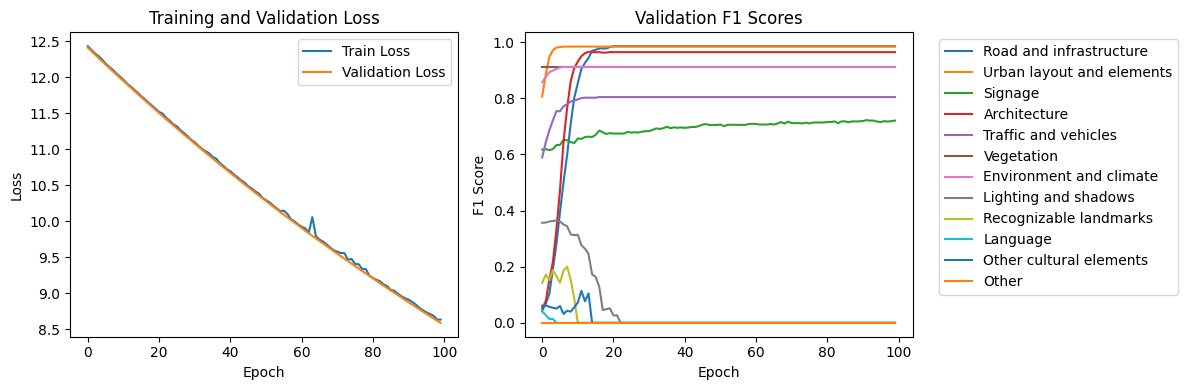

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Convert your labels to binary tensors
label_columns = ['Road and infrastructure', 'Urban layout and elements', 'Signage', 'Architecture', 'Traffic and vehicles', 'Vegetation', 'Environment and climate', 'Lighting and shadows', 'Recognizable landmarks', 'Language', 'Other cultural elements', 'Other']
labels = categories_df[label_columns].values

# Get the text responses
texts = categories_df['model_response'].values

class GeoReasoningClassifier(nn.Module):
    def __init__(self, transformer_model="all-MiniLM-L6-v2"):
        super().__init__()
        self.transformer = SentenceTransformer(transformer_model)
        self.classifier = nn.Linear(384, len(label_columns))
        self.sigmoid = nn.Sigmoid()

    def forward(self, embeddings):
        return self.sigmoid(self.classifier(embeddings))

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Create model and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GeoReasoningClassifier().to(device)

# Create datasets
train_embeddings = model.transformer.encode(X_train, convert_to_tensor=True)
val_embeddings = model.transformer.encode(X_val, convert_to_tensor=True)

train_dataset = TensorDataset(train_embeddings.to(device), torch.FloatTensor(y_train).to(device))
val_dataset = TensorDataset(val_embeddings.to(device), torch.FloatTensor(y_val).to(device))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Calculate class weights
def calculate_class_weights(labels):
    pos_counts = labels.sum(axis=0)
    neg_counts = len(labels) - pos_counts
    pos_weights = neg_counts / pos_counts
    return torch.FloatTensor(pos_weights).to(device)

# Training history
class TrainingHistory:
    def __init__(self):
        self.train_losses = []
        self.val_losses = []
        self.val_accuracies = []
        self.val_f1_scores = []

    def update(self, train_loss, val_loss, val_accuracies, val_f1):
        self.train_losses.append(train_loss)
        self.val_losses.append(val_loss)
        self.val_accuracies.append(val_accuracies)
        self.val_f1_scores.append(val_f1)

def calculate_metrics(predictions, labels):
    # Calculate F1 score for each class
    eps = 1e-7
    predictions = np.array(predictions)
    labels = np.array(labels)

    tp = np.sum(predictions * labels, axis=0)
    fp = np.sum(predictions * (1 - labels), axis=0)
    fn = np.sum((1 - predictions) * labels, axis=0)

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * (precision * recall) / (precision + recall + eps)

    return precision, recall, f1

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for embeddings, labels in dataloader:
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predictions.extend((outputs > 0.5).float().cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    accuracies = (predictions == true_labels).mean(axis=0)
    precision, recall, f1 = calculate_metrics(predictions, true_labels)

    return avg_loss, accuracies, f1

# Calculate class weights
class_weights = calculate_class_weights(labels)

# Modified loss function with class weights
criterion = nn.BCELoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

# Initialize history
history = TrainingHistory()

# Training loop
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(100):
    model.train()
    train_loss = 0

    for batch_embeddings, batch_labels in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)

    # Validation
    val_loss, val_accuracies, val_f1 = evaluate(model, val_loader, criterion)

    # Update history
    history.update(train_loss, val_loss, val_accuracies, val_f1)

    # Print metrics
    print(f'Epoch {epoch+1}:')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Val Loss: {val_loss:.4f}')
    print('Validation Metrics per category:')
    for i, cat in enumerate(label_columns):
        print(f'{cat}:')
        print(f'  Accuracy: {val_accuracies[i]:.4f}')
        print(f'  F1-Score: {val_f1[i]:.4f}')
    print()

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'epoch': epoch,
        }, 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

# Plotting training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.train_losses, label='Train Loss')
    plt.plot(history.val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot F1 scores
    plt.subplot(1, 2, 2)
    for i, cat in enumerate(label_columns):
        f1_scores = [f1[i] for f1 in history.val_f1_scores]
        plt.plot(f1_scores, label=cat)
    plt.title('Validation F1 Scores')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Load best model for inference
def predict(text, model):
    model.eval()
    embedding = model.transformer.encode(text, convert_to_tensor=True).to(device)
    with torch.no_grad():
        predictions = model(embedding)
    return (predictions > 0.5).float().cpu().numpy()

# Example usage:
# model.load_state_dict(torch.load('best_model.pt'))
# predictions = predict("Your text here", model)

In [ ]:
# prompt: use model to predict all model_responses, and compare accuracy with actual labels

# Load the best model
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Predict on all model responses
all_predictions = []
for text in texts:
    all_predi ctions.append(predict(text, model))

# Calculate accuracy for all predictions
all_predictions = np.array(all_predictions)
accuracy = np.mean(all_predictions == labels)
print(f"Overall Accuracy: {accuracy}")

# Calculate accuracy per category
for i, category in enumerate(label_columns):
    category_accuracy = np.mean(all_predictions[:, i] == labels[:, i])
    print(f"Accuracy for {category}: {category_accuracy}")

<ipython-input-10-85bec58982a2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pt')


Overall Accuracy: 0.842852684144819
Accuracy for Road and infrastructure: 0.9794007490636704
Accuracy for Urban layout and elements: 0.9612983770287141
Accuracy for Signage: 0.6548064918851436
Accuracy for Architecture: 0.920099875156055
Accuracy for Traffic and vehicles: 0.6591760299625468
Accuracy for Vegetation: 0.8426966292134831
Accuracy for Environment and climate: 0.8414481897627965
Accuracy for Lighting and shadows: 0.7871410736579276
Accuracy for Recognizable landmarks: 0.9388264669163545
Accuracy for Language: 0.5624219725343321
Accuracy for Other cultural elements: 0.9731585518102372
Accuracy for Other: 0.9937578027465668


In [ ]:
# prompt: explain np.where(np.array(keyword_matches), 1, model_prediction)

keyword_matches = [True, False, True, False]
model_prediction = [0.2, 0.8, 0.1, 0.9]
np.where(np.array(keyword_matches), 1, model_prediction)

array([1. , 0.8, 1. , 0.9])

In [ ]:
# prompt: use model's prediction + detecting keywords for each cateogory in the model_response and measure accuracy again

import re

def predict_with_keywords(text, model, keywords):
    # Model prediction
    model_prediction = predict(text, model)

    # Keyword detection
    keyword_matches = [any(re.search(keyword, text, re.IGNORECASE) for keyword in category_keywords) for category_keywords in keywords]

    # Combine model prediction and keyword detection
    combined_prediction = np.where(np.array(keyword_matches), 1, model_prediction)

    return combined_prediction


# Example keywords (expand this list for each category)
keywords = [
    ["road", "infrastructure", "highway", "street", "intersection", "lane", "pavement", "bridge"],  # Road and infrastructure
    ["city", "town", "urban", "building", "block", "layout", "street"],  # Urban layout and elements
    ["sign", "signal", "traffic sign", "stop sign", "signage"],  # Signage
    ["building", "architecture", "house", "structure", "style"],  # Architecture
    ["car", "vehicle", "truck", "traffic", "bus"],  # Traffic and vehicles
    ["tree", "plant", "forest", "vegetation", "park"],  # Vegetation
    ["environment", "weather", "climate", "pollution"],  # Environment and climate
    ["light", "shadow", "illumination"],  # Lighting and shadows
    ["landmark", "monument", "tower", "statue", "famous"],  # Recognizable landmarks
    ["language", "words", "text", "writing", "letters", "characters"],  # Language
    ["culture", "tradition", "art", "history", "clothing", "people", "clothes"],  # Other cultural elements
    ["other"]  # Other
]


# Predict with keywords
all_predictions_with_keywords = []
for i, text in enumerate(texts):
    all_predictions_with_keywords.append(predict_with_keywords(text, model, keywords))

all_predictions_with_keywords = np.array(all_predictions_with_keywords)

# Calculate accuracy for all predictions
accuracy_with_keywords = np.mean(all_predictions_with_keywords == labels)
print(f"Overall Accuracy (with keywords): {accuracy_with_keywords}")


# Calculate accuracy per category
for i, category in enumerate(label_columns):
    category_accuracy = np.mean(all_predictions_with_keywords[:, i] == labels[:, i])
    print(f"Accuracy for {category} (with keywords): {category_accuracy}")

Overall Accuracy (with keywords): 0.7866208905534748
Accuracy for Road and infrastructure (with keywords): 0.9794007490636704
Accuracy for Urban layout and elements (with keywords): 0.9612983770287141
Accuracy for Signage (with keywords): 0.5986267166042447
Accuracy for Architecture (with keywords): 0.920099875156055
Accuracy for Traffic and vehicles (with keywords): 0.6591760299625468
Accuracy for Vegetation (with keywords): 0.8426966292134831
Accuracy for Environment and climate (with keywords): 0.8414481897627965
Accuracy for Lighting and shadows (with keywords): 0.7153558052434457
Accuracy for Recognizable landmarks (with keywords): 0.9051186017478152
Accuracy for Language (with keywords): 0.7103620474406991
Accuracy for Other cultural elements (with keywords): 0.42446941323345816
Accuracy for Other (with keywords): 0.8813982521847691


In [ ]:
# prompt: discover top keywords related to the categories in model_responses from all rows, words related to the categories in the embeddings with the ['Road and infrastructure', 'Urban layout and elements', 'Signage', 'Architecture', 'Traffic and vehicles', 'Vegetation', 'Environment and climate', 'Lighting and shadows', 'Recognizable landmarks', 'Language', 'Other cultural elements', 'Other'], remove common words

from collections import Counter

def get_top_keywords(texts, categories, top_n=30):
    """
    Discovers top keywords related to categories in texts.
    """
    all_keywords = {}
    for i, text in enumerate(texts):
        for j, category in enumerate(categories):
            if labels[i,j] == 1: # If the category is active for this text
                if category not in all_keywords:
                    all_keywords[category] = []
                words = re.findall(r'\b\w+\b', text.lower()) # Extract words
                all_keywords[category].extend(words)

    top_keywords = {}
    for category, words in all_keywords.items():
        word_counts = Counter(words)
        # Remove common words (you might want to customize this list)
        common_words = ["the", "a", "an", "of", "to", "in", "is", "it", "and", "that", "for", "with", "on", "as", "are", "by", "be", "at", "this"]
        filtered_word_counts = {word: count for word, count in word_counts.items() if word not in common_words}

        top_keywords[category] = [word for word, count in sorted(filtered_word_counts.items(), key=lambda item: item[1], reverse=True)[:top_n]]
    return top_keywords

top_keywords_per_category = get_top_keywords(texts, label_columns)
top_keywords_per_category

{'Road and infrastructure': ['location',
  'city',
  'or',
  's',
  'style',
  'guess',
  'common',
  'country',
  'clues',
  'which',
  'road',
  'image',
  'architecture',
  'climate',
  'urban',
  'these',
  'vegetation',
  'street',
  'typical',
  'based',
  'likely',
  '3',
  'area',
  '1',
  '4',
  '2',
  'determine',
  'json',
  'let',
  'analyze'],
 'Urban layout and elements': ['location',
  'city',
  'or',
  's',
  'style',
  'guess',
  'country',
  'common',
  'clues',
  'which',
  'architecture',
  'image',
  'urban',
  'road',
  'climate',
  'these',
  'street',
  'typical',
  'based',
  'vegetation',
  'likely',
  '3',
  'area',
  '1',
  '4',
  '2',
  'determine',
  'json',
  'let',
  'analyze'],
 'Architecture': ['location',
  'city',
  'or',
  's',
  'style',
  'guess',
  'country',
  'common',
  'architecture',
  'clues',
  'which',
  'image',
  'urban',
  'climate',
  'street',
  'these',
  'road',
  'typical',
  'based',
  'likely',
  'vegetation',
  '3',
  '1',
  '4

In [ ]:
# prompt: AttributeError                            Traceback (most recent call last)
# <ipython-input-19-60503be97303> in <cell line: 28>()
#      26     return top_keywords
#      27
# ---> 28 top_keywords_per_category = get_top_keywords(texts, label_columns)
#      29 top_keywords_per_category
# <ipython-input-19-60503be97303> in get_top_keywords(texts, categories, top_n)
#      23         filtered_word_counts = {word: count for word, count in word_counts.items() if word not in common_words}
#      24
# ---> 25         top_keywords[category] = [word for word, count in filtered_word_counts.most_common(top_n)]
#      26     return top_keywords
#      27
# AttributeError: 'dict' object has no attribute 'most_common'

def get_top_keywords(texts, categories, top_n=10):
    """
    Discovers top keywords related to categories in texts.
    """
    all_keywords = {}
    for i, text in enumerate(texts):
        for j, category in enumerate(categories):
            if labels[i,j] == 1: # If the category is active for this text
                if category not in all_keywords:
                    all_keywords[category] = []
                words = re.findall(r'\b\w+\b', text.lower()) # Extract words
                all_keywords[category].extend(words)

    top_keywords = {}
    for category, words in all_keywords.items():
        word_counts = Counter(words)
        # Remove common words (you might want to customize this list)
        common_words = ["the", "a", "an", "of", "to", "in", "is", "it", "and", "that", "for", "with", "on", "as", "are", "by", "be", "at", "this"]
        filtered_word_counts = {word: count for word, count in word_counts.items() if word not in common_words}

        top_keywords[category] = [word for word, count in sorted(filtered_word_counts.items(), key=lambda item: item[1], reverse=True)[:top_n]]
    return top_keywords

In [ ]:
def predict(text, model):
    model.eval()
    embedding = model.transformer.encode(text, convert_to_tensor=True).to(device)
    with torch.no_grad():
        predictions = model(embedding)
    return (predictions > 0.5).float().cpu().numpy()

a = predict("Your text here", model)

In [ ]:
a

array([1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
claude_35_df = pd.read_csv('/content/claude-3-5-sonnet_full_bench.csv')
gemini_df = pd.read_csv('/content/gemini-1-5-flash-full-bench.csv')

In [ ]:
# prompt: loop through entirety of 'model_response' column and get all bolded words after numbered list (1. **Vegetation** 2. **Street and housese** --> ['vegetation','street and houses'])

import re

bolded_words_list = []

for response in gpt4o_df['model_response']:
  if isinstance(response, str):
    # Find all bolded words after a numbered list
    matches = re.findall(r'\d+\.\s+\*\*(.+?)\*\*', response)
    if matches:
      for match in matches:
        bolded_words_list.append(match.lower())

print(bolded_words_list)

['architecture', 'vegetation', 'cars', 'street and sidewalk', 'fence and utility pole', 'vegetation and environment', 'signage', 'pathway and infrastructure', 'coastal clues', 'language and signs', 'architecture and infrastructure', 'bus design and advertisement', 'sky and weather', 'street layout', 'coastal environment', 'vegetation and landscape', 'architecture and infrastructure', 'sky and weather', 'geographical features', 'water tower', 'vegetation and climate', 'road and infrastructure', 'surroundings', 'language and signage', 'architecture and street layout', 'business names', 'vehicle and road', 'architecture', 'businesses', 'signage', 'street features', 'road and guardrail', 'vegetation', 'road condition and markings', 'sky and weather', 'geography', 'architecture and vegetation', 'road markings and signs', 'vehicles', 'seasonal clues', 'general environment', 'business name', 'architecture and signage', 'vehicles', 'surroundings', 'sky and weather', 'architecture', 'vegetation

In [ ]:
len(gpt4o_df)

1602

In [ ]:
# prompt:   "Road and infrastructure": 0 or 1,
#   "Urban layout and elements": 0 or 1,
#   "Signage": 0 or 1,
#   "Architecture": 0 or 1,
#   "Traffic and vehicles": 0 or 1,
#   "Vegetation": 0 or 1,
#   "Environment and climate": 0 or 1,
#   "Lighting and shadows": 0 or 1,
#   "Recognizable landmarks": 0 or 1,
#   "Language": 0 or 1,
#   "Other cultural elements": 0 or 1,
#   "Other": 0 or 1
# run every response in model response and label it for these categories

# "Road and infrastructure": 0 or 1,
# "Urban layout and elements": 0 or 1,
# "Signage": 0 or 1,
# "Architecture": 0 or 1,
# "Traffic and vehicles": 0 or 1,
# "Vegetation": 0 or 1,
# "Environment and climate": 0 or 1,
# "Lighting and shadows": 0 or 1,
# "Recognizable landmarks": 0 or 1,
# "Language": 0 or 1,
# "Other cultural elements": 0 or 1,
# "Other": 0 or 1
all_labels = []

def label_response(response):
  labels = {
      "Road and infrastructure": 0,
      "Urban layout and elements": 0,
      "Signage": 0,
      "Architecture": 0,
      "Traffic and vehicles": 0,
      "Vegetation": 0,
      "Environment and climate": 0,
      "Lighting and shadows": 0,
      "Recognizable landmarks": 0,
      "Language": 0,
      "Other cultural elements": 0,
      "Other": 0
  }

  if isinstance(response, str):
    if "road" in response.lower() or "infrastructure" in response.lower() or "highway" in response.lower() or "bridge" in response.lower():
      labels["Road and infrastructure"] = 1
    if "urban" in response.lower() or "layout" in response.lower() or "city" in response.lower() or "street" in response.lower():
      labels["Urban layout and elements"] = 1
    if "sign" in response.lower() or "signage" in response.lower():
      labels["Signage"] = 1
    if "architecture" in response.lower() or "building" in response.lower():
      labels["Architecture"] = 1
    if "traffic" in response.lower() or "vehicle" in response.lower() or "car" in response.lower():
      labels["Traffic and vehicles"] = 1
    if "vegetation" in response.lower() or "plant" in response.lower() or "tree" in response.lower():
      labels["Vegetation"] = 1
    if "environment" in response.lower() or "climate" in response.lower() or "weather" in response.lower():
      labels["Environment and climate"] = 1
    if "lighting" in response.lower() or "shadow" in response.lower():
      labels["Lighting and shadows"] = 1
    if "landmark" in response.lower() or "famous" in response.lower():
      labels["Recognizable landmarks"] = 1
    if "language" in response.lower():
      labels["Language"] = 1
    if "culture" in response.lower() or "tradition" in response.lower():
      labels["Other cultural elements"] = 1

  return labels


# Example usage with gpt4o_df
for response in gpt4o_df['model_response']:
  labels = label_response(response)
  print(labels) # Do something with the labels, e.g., add them to a new column in the DataFrame
  all_labels.append(labels)

{'Road and infrastructure': 0, 'Urban layout and elements': 1, 'Signage': 1, 'Architecture': 1, 'Traffic and vehicles': 1, 'Vegetation': 1, 'Environment and climate': 1, 'Lighting and shadows': 0, 'Recognizable landmarks': 0, 'Language': 0, 'Other cultural elements': 0, 'Other': 0}
{'Road and infrastructure': 1, 'Urban layout and elements': 1, 'Signage': 1, 'Architecture': 0, 'Traffic and vehicles': 0, 'Vegetation': 1, 'Environment and climate': 1, 'Lighting and shadows': 0, 'Recognizable landmarks': 0, 'Language': 0, 'Other cultural elements': 0, 'Other': 0}
{'Road and infrastructure': 1, 'Urban layout and elements': 1, 'Signage': 1, 'Architecture': 1, 'Traffic and vehicles': 0, 'Vegetation': 1, 'Environment and climate': 1, 'Lighting and shadows': 0, 'Recognizable landmarks': 0, 'Language': 1, 'Other cultural elements': 0, 'Other': 0}
{'Road and infrastructure': 1, 'Urban layout and elements': 1, 'Signage': 0, 'Architecture': 1, 'Traffic and vehicles': 0, 'Vegetation': 1, 'Environmen

In [ ]:
n = 50
print(all_labels[n])
print(gpt4o_df['model_response'][n])

{'Road and infrastructure': 1, 'Urban layout and elements': 1, 'Signage': 1, 'Architecture': 1, 'Traffic and vehicles': 0, 'Vegetation': 1, 'Environment and climate': 1, 'Lighting and shadows': 0, 'Recognizable landmarks': 0, 'Language': 0, 'Other cultural elements': 0, 'Other': 0}
To determine the location of this image, let's analyze the visual clues:

1. **Vegetation and Climate**: The lush greenery and tropical plants suggest a warm, humid climate typical of Southeast Asia or similar regions.

2. **Road and Infrastructure**: The narrow, concrete road with simple houses and overhead power lines is common in rural or suburban areas in countries like the Philippines, Thailand, or Indonesia.

3. **Signage**: The sign on the left side of the road is in English, which is widely used in the Philippines. The style of the sign and the presence of English text are strong indicators of this country.

4. **Architecture**: The houses have a style that is consistent with rural areas in the Phili

In [ ]:
!pip install sentence-transformers --quiet
import re

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.2/255.2 kB 4.0 MB/s eta 0:00:00


In [ ]:
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import KMeans

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(bolded_words_list)

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings)

cluster_labels = kmeans.labels_

for i in range(num_clusters):
  print(f"Cluster {i}:")
  for j, word in enumerate(bolded_words_list):
    if cluster_labels[j] == i:
      print(word)
  print()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Streaming output truncated to the last 5000 lines.
vegetation
desert landscape
vegetation
vegetation
vegetation
vegetation and climate
vegetation and environment
vegetation
vegetation
vegetation
vegetation
vegetation
vegetation
vegetation
vegetation
vegetation
vegetation
vegetation
vegetation and climate
vegetation
vegetation and climate
vegetation
vegetation and trees
vegetation and climate
vegetation and climate
vegetation
vegetation and terrain
vegetation
vegetation
vegetation
vegetation
climate and vegetation
vegetation
vegetation
vegetation
weather and vegetation
vegetation and environment
vegetation and climate
vegetation and climate
vegetation
vegetation
landscape and vegetation
vegetation
vegetation and environment
vegetation
vegetation and environment
climate and vegetation
vegetation and landscaping
vegetation
vegetation and park setting
vegetation
vegetation
vegetation and landscape
vegetation and climate
vegetation
vegetation
vegetation
vegetation and landscape
vegetation
v

In [ ]:
# prompt: plot the interactive tsne WITH the text

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=0)
tsne_embeddings = tsne.fit_transform(embeddings)

# Create a DataFrame with t-SNE coordinates, cluster labels, and the original words
tsne_df = pd.DataFrame({'x': tsne_embeddings[:, 0], 'y': tsne_embeddings[:, 1], 'cluster': cluster_labels, 'word': bolded_words_list})

# Create an interactive scatter plot using Plotly Express with hover text showing the original words
fig = px.scatter(tsne_df, x='x', y='y', color='cluster', hover_data=['word', 'cluster'])
fig.update_layout(title='t-SNE Visualization of Clusters', xaxis_title='t-SNE Dimension 1', yaxis_title='t-SNE Dimension 2')
fig.show()

In [ ]:
# prompt: export the plot to html

fig.write_html("tsne_plot.html")

In [ ]:
prompt = """You are an expert text annotator. Your task is to label a piece of text describing someone's geolocation guessing process, identifying the details they used to make their guess.

Here are the categories of details to consider:

1. Road and infrastructure: Details related to roads, infrastructure on roads, pavements, or sidewalks.
2. Urban layout and elements: Features related to street layout, building density, urban planning, etc.
3. Signage: Traffic signs, shop signs, billboards, etc.
4. Architecture: Buildings, structures, materials, architectural styles, etc.
5. Traffic and vehicles: Types of vehicles, license plates, car models, traffic patterns, utility vehicles, etc.
6. Vegetation: Plants, trees, etc.
7. Environment and climate: Sky, weather, landscape features, terrain, etc.
8. Lighting and shadows: Used to guess hemisphere, time of day, season, etc.
9. Recognizable landmarks: Specific, identifiable places or structures.
10. Language: Text on signs, buildings, or overheard speech.
11. Other cultural elements: Clothing, festivals, customs, etc. (not including language).
12. Other: Any other details that don't fit the above categories.

Please note that you are NOT supposed to guess the location, nor do you have access to the image, but you are supposed to label the guess made in the text.

Please output ONLY the JSON and nothing else.

Please output the labels in the following JSON format:
{
  "Road and infrastructure": 0 or 1,
  "Urban layout and elements": 0 or 1,
  "Signage": 0 or 1,
  "Architecture": 0 or 1,
  "Traffic and vehicles": 0 or 1,
  "Vegetation": 0 or 1,
  "Environment and climate": 0 or 1,
  "Lighting and shadows": 0 or 1,
  "Recognizable landmarks": 0 or 1,
  "Language": 0 or 1,
  "Other cultural elements": 0 or 1,
  "Other": 0 or 1
}

Use 1 if the feature was clearly used in the guess, and 0 if it wasn't.

Note that the JSON you output is for binary labelling of the categories, NOT the coordinates and location.

Here is the text to be labelled:

"""

In [ ]:
import anthropic
def response_claude(api_key, prompt):
    client = anthropic.Anthropic()

    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1024,
        temperature=0,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": f"{prompt}"
                    }
                ],
            }
        ],
    )
    # get content with message.content[0].text
    return message

In [ ]:
import pandas as pd
labels_df = pd.read_csv('/content/gpt4o_categories_merged.csv')
labels_df.head()

Road and infrastructure  Urban layout and elements  Signage  Architecture  \
0                        1                          1        0             1   
1                        1                          1        0             1   
2                        1                          1        1             1   
3                        1                          1        1             1   
4                        1                          1        1             1   

   Traffic and vehicles  Vegetation  Environment and climate  \
0                     1           1                        1   
1                     1           1                        1   
2                     1           1                        1   
3                     1           1                        1   
4                     1           1                        1   

   Lighting and shadows  Recognizable landmarks  Language  \
0                     0                       0         0   
1                     0                       0         0   
2                     0                       0         1   
3                     0                       0         1   
4                     0                       0         1   

   Other cultural elements  Other  \
0                        0      0   
1                        0      0   
2                        0      0   
3                        0      0   
4                        0      0   

                                                 raw  
0  {\n  "Road and infrastructure": 1,\n  "Urban l...  
1  {\n  "Road and infrastructure": 1,\n  "Urban l...  
2  {\n  "Road and infrastructure": 1,\n  "Urban l...  
3  {\n  "Road and infrastructure": 1,\n  "Urban l...  
4  {\n  "Road and infrastructure": 1,\n  "Urban l...

In [ ]:
road_and_infrastructure = labels_df['Road and infrastructure']
urban_layout_and_elements = labels_df['Urban layout and elements']
signage = labels_df['Signage']
architecture = labels_df['Architecture']
traffic_and_vehicles = labels_df['Traffic and vehicles']
vegetation = labels_df['Vegetation']
environment_and_climate = labels_df['Environment and climate']
lighting_and_shadows = labels_df['Lighting and shadows']
recognizable_landmarks = labels_df['Recognizable landmarks']
language = labels_df['Language']
other_cultural_elements = labels_df['Other cultural elements']
other = labels_df['Other']
reasoning = labels_df['raw']

In [ ]:
len(urban_layout_and_elements)

1249

In [ ]:
# prompt: print tqdm progress bar

from tqdm import tqdm

# Assuming 'texts' is defined somewhere in your existing code
# Example usage:
for i in tqdm(range(len(texts)), desc="Processing texts"):
    # Your existing code to process each text
    pass

In [ ]:
import json
import tqdm

all_labels = []
all_labels_reasonings = []

for i in range(0, len(gpt4o_df['model_response'])):
  prompt = prompt + gpt4o_df['model_response'][i]
  labels = response_claude(os.environ['ANTHROPIC_API_KEY'], prompt).content[0].text

  all_labels_reasonings.append(labels)
  start = labels.find('{')
  end = labels.rfind('}')
  labels = labels[start:end+1]
  print(labels)
  try:
    labels_dict = json.loads(labels)
    if list(labels_dict.keys())[0] != 'Road and infrastructure':
      print("ERROR")
      all_labels.append(None)
    else:
      all_labels.append(labels_dict)

  except json.JSONDecodeError:
    print("JSON decoding error")
    all_labels.append(None)
  print("progress percentage: " + str(i/len(gpt4o_df['model_response'])*100) + "%")


  #all_labels.append(json.loads(labels))

# for response in gpt4o_df['model_response']:
#   prompt = prompt + response
#   labels = response_claude(os.environ['ANTHROPIC_API_KEY'], prompt).content[0].text
#   all_labels_reasonings.append(labels)

#   start = labels.find('{')
#   end = labels.rfind('}')
#   labels = labels[start:end+1]
#   print(labels)
#   all_labels.append(json.loads(labels))


Streaming output truncated to the last 5000 lines.
  "Urban layout and elements": 1,
  "Signage": 1,
  "Architecture": 1,
  "Traffic and vehicles": 1,
  "Vegetation": 1,
  "Environment and climate": 1,
  "Lighting and shadows": 0,
  "Recognizable landmarks": 0,
  "Language": 0,
  "Other cultural elements": 0,
  "Other": 0
}
progress percentage: 14.66916354556804%
{
  "Road and infrastructure": 1,
  "Urban layout and elements": 1,
  "Signage": 0,
  "Architecture": 1,
  "Traffic and vehicles": 1,
  "Vegetation": 1,
  "Environment and climate": 1,
  "Lighting and shadows": 0,
  "Recognizable landmarks": 0,
  "Language": 0,
  "Other cultural elements": 0,
  "Other": 0
}
progress percentage: 14.731585518102372%
{
  "Road and infrastructure": 1,
  "Urban layout and elements": 1,
  "Signage": 0,
  "Architecture": 1,
  "Traffic and vehicles": 0,
  "Vegetation": 1,
  "Environment and climate": 1,
  "Lighting and shadows": 1,
  "Recognizable landmarks": 0,
  "Language": 0,
  "Other cultural elem

In [ ]:
922

In [ ]:
all_labels_reasonings.pop(-1)

'To determine the location depicted in the image, let\'s analyze the visual clues:\n\n1. **Architecture**: The buildings have a modern, urban design typical of East Asian cities. The use of concrete and glass is common in Japanese architecture.\n\n2. **Language**: The signs appear to be in Japanese, which strongly indicates this is in Japan.\n\n3. **Street Layout**: The narrow street and the style of the sidewalk are characteristic of Japanese urban areas.\n\n4. **Infrastructure**: The overhead power lines and utility poles are arranged in a way that\'s typical in Japanese cities.\n\n5. **Vehicles**: The cars are parked in a manner consistent with Japanese parking regulations.\n\nBased on these observations, the location is likely in Japan, specifically in a major city. Given the modern urban setting and architectural style, this could be in Tokyo.\n\nHere is the best guess for the coordinates:\n\n```json\n{\n  "lat": 35.6895,\n  "long": 139.6917,\n  "city": "Tokyo",\n  "country": "Jap

In [ ]:
all_labels_reasonings[-1]

'To determine the location depicted in the image, let\'s analyze the visual clues:\n\n1. **Architecture**: The buildings have a modern, urban design typical of North American cities. The presence of high-rise buildings suggests a major metropolitan area.\n\n2. **Road and Infrastructure**: The road appears to be well-maintained with clear markings, indicating a developed urban area.\n\n3. **Vegetation**: The trees and landscaping suggest a temperate climate, common in many parts of North America.\n\n4. **Street Layout**: The wide street and the presence of multiple lanes indicate a major thoroughfare in a city.\n\n5. **Sky and Weather**: The clear sky and lighting conditions are consistent with many North American cities.\n\nBased on these observations, the location is likely in a major city in North America. The architectural style and urban planning suggest a city like Minneapolis or St. Paul.\n\nHere\'s the best guess for the coordinates:\n\n```json\n{\n  "lat": 44.9778,\n  "long": -

In [ ]:
gpt4o_df['model_response'][1017]

'To determine the location in the image, let\'s analyze the visual clues:\n\n1. **Architecture and Infrastructure**: The buildings and road infrastructure suggest an urban area in a developing country. The presence of a large communication tower is notable.\n\n2. **Vehicles and Traffic**: The vehicles, including the red truck, have a design common in West African countries. The traffic flow and road markings can also provide hints.\n\n3. **Signage and Language**: The signs are in English, which narrows it down to English-speaking countries in Africa.\n\n4. **Vegetation and Climate**: The vegetation and sky suggest a tropical climate, typical of West Africa.\n\n5. **Cultural and Commercial Elements**: The presence of specific advertisements and commercial activity can be indicative of a bustling city center.\n\nBased on these observations, the location is likely in Ghana, specifically in the city of Kumasi. The image appears to be taken near a central area with significant commercial ac

In [ ]:
len(all_labels)

NameError: name 'all_labels' is not defined

In [ ]:
754 + 495 + 353

1602

In [ ]:
754

In [ ]:
for i in range(len(all_labels)):
  print(str(i) + " " + str(all_labels[i]))

0 {'Road and infrastructure': 1, 'Urban layout and elements': 1, 'Signage': 0, 'Architecture': 1, 'Traffic and vehicles': 0, 'Vegetation': 1, 'Environment and climate': 1, 'Lighting and shadows': 0, 'Recognizable landmarks': 0, 'Language': 0, 'Other cultural elements': 0, 'Other': 0}
1 {'Road and infrastructure': 1, 'Urban layout and elements': 1, 'Signage': 0, 'Architecture': 1, 'Traffic and vehicles': 0, 'Vegetation': 1, 'Environment and climate': 1, 'Lighting and shadows': 0, 'Recognizable landmarks': 0, 'Language': 0, 'Other cultural elements': 0, 'Other': 0}
2 {'Road and infrastructure': 1, 'Urban layout and elements': 1, 'Signage': 0, 'Architecture': 1, 'Traffic and vehicles': 0, 'Vegetation': 1, 'Environment and climate': 1, 'Lighting and shadows': 0, 'Recognizable landmarks': 0, 'Language': 0, 'Other cultural elements': 0, 'Other': 0}
3 {'Road and infrastructure': 1, 'Urban layout and elements': 1, 'Signage': 0, 'Architecture': 1, 'Traffic and vehicles': 0, 'Vegetation': 1, 'En

In [ ]:
categories = [
    "Road and infrastructure",
    "Urban layout and elements",
    "Signage",
    "Architecture",
    "Traffic and vehicles",
    "Vegetation",
    "Environment and climate",
    "Lighting and shadows",
    "Recognizable landmarks",
    "Language",
    "Other cultural elements",
    "Other"
]

category_lists = {category: [] for category in categories}

for item in all_labels:
    for category in categories:
        category_lists[category].append(item.get(category, 0))

In [ ]:
# prompt: export categories to df

df_categories = pd.DataFrame(category_lists)
df_categories['raw'] = all_labels_reasonings
print(df_categories)

     Road and infrastructure  Urban layout and elements  Signage  \
0                          1                          1        0   
1                          1                          1        0   
2                          1                          1        0   
3                          1                          1        0   
4                          1                          1        1   
..                       ...                        ...      ...   
348                        1                          1        1   
349                        1                          1        1   
350                        1                          1        0   
351                        1                          1        0   
352                        1                          1        1   

     Architecture  Traffic and vehicles  Vegetation  Environment and climate  \
0               1                     0           1                        1   
1               1      

In [ ]:
df_categories.to_csv('gpt4o_categories_tomp.csv', index=False)

In [ ]:
# prompt: merge /content/gpt4o_categories_temp.csv and /content/gpt4o_categories_tomp.csv

import pandas as pd

# Load the two CSV files into pandas DataFrames
df1 = pd.read_csv('/content/gpt4o_categories_merged.csv')
df2 = pd.read_csv('/content/gpt4o_categories_tomp.csv')

# Concatenate the two DataFrames vertically
merged_df = pd.concat([df1, df2], ignore_index=True)

# Save the merged DataFrame to a new CSV file
#merged_df.to_csv('gpt4o_categories_final.csv', index=False)

In [ ]:
merged_df.head()

Road and infrastructure  Urban layout and elements  Signage  Architecture  \
0                        1                          1        0             1   
1                        1                          1        0             1   
2                        1                          1        1             1   
3                        1                          1        1             1   
4                        1                          1        1             1   

   Traffic and vehicles  Vegetation  Environment and climate  \
0                     1           1                        1   
1                     1           1                        1   
2                     1           1                        1   
3                     1           1                        1   
4                     1           1                        1   

   Lighting and shadows  Recognizable landmarks  Language  \
0                     0                       0         0   
1                     0                       0         0   
2                     0                       0         1   
3                     0                       0         1   
4                     0                       0         1   

   Other cultural elements  Other  \
0                        0      0   
1                        0      0   
2                        0      0   
3                        0      0   
4                        0      0   

                                                 raw  
0  {\n  "Road and infrastructure": 1,\n  "Urban l...  
1  {\n  "Road and infrastructure": 1,\n  "Urban l...  
2  {\n  "Road and infrastructure": 1,\n  "Urban l...  
3  {\n  "Road and infrastructure": 1,\n  "Urban l...  
4  {\n  "Road and infrastructure": 1,\n  "Urban l...

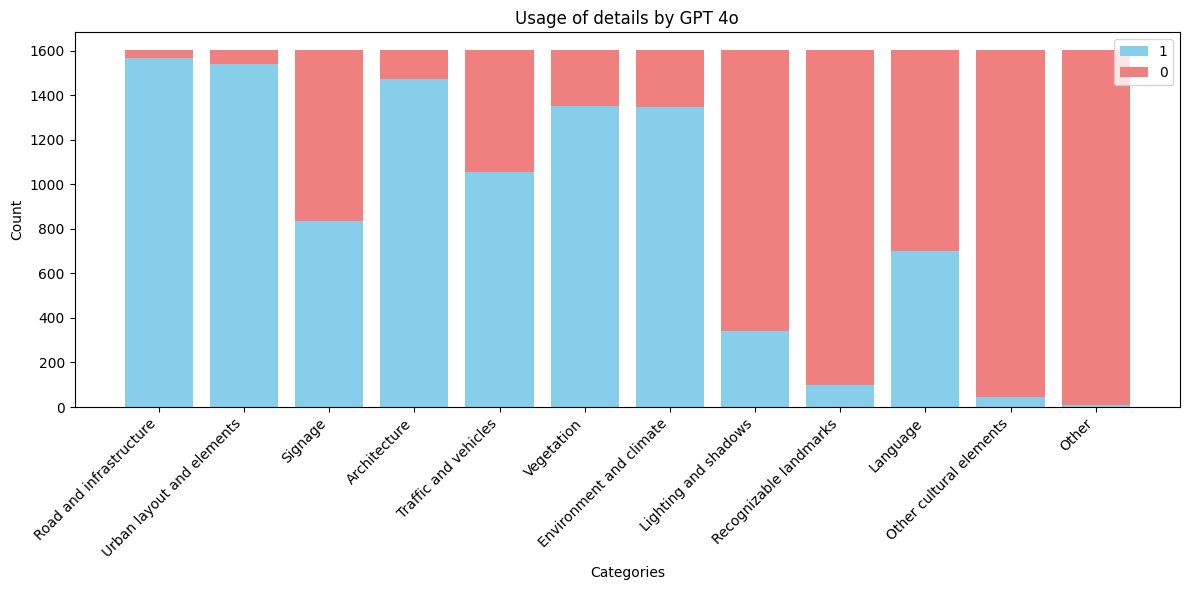

In [ ]:
# prompt: count all 1 values all columns in plot merged_df except for raw, image_name, distance and plot the values, get len of the df and subtract that from counts of 1, and plot a different colour bar above 1 as 0

import pandas as pd
import matplotlib.pyplot as plt

# Assuming merged_df is already loaded as in your provided code
# ... (your existing code to load and process merged_df) ...

# Columns to exclude from the count
exclude_cols = ['raw', 'image_name', 'distance']

# Select columns for analysis, excluding specified columns
cols_to_analyze = [col for col in merged_df.columns if col not in exclude_cols]

# Calculate the count of '1' values in each column
counts_of_ones = merged_df[cols_to_analyze].sum()

# Get the length of the DataFrame
df_len = len(merged_df)

# Calculate the count of '0' values (length - count of '1' values)
counts_of_zeros = df_len - counts_of_ones


# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the counts of '1' values
ax.bar(counts_of_ones.index, counts_of_ones.values, label='1', color='skyblue')

# Plot the counts of '0' values above the '1' values
ax.bar(counts_of_zeros.index, counts_of_zeros.values, bottom=counts_of_ones.values, label='0', color='lightcoral')


# Customize the plot
ax.set_xlabel("Categories")
ax.set_ylabel("Count")
ax.set_title("Usage of details by GPT 4o")
ax.legend()
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
image_names = gpt4o_df['image_name']
distance = gpt4o_df['distance']
merged_df.insert(0, 'image_name', image_names)
merged_df.insert(1, 'distance', distance)
merged_df.to_csv('gpt4o_categories_final.csv', index=False)

In [ ]:
/content/claude-3-5-sonnet-_categories.csv
/content/claude-3-5-sonnet_full_bench.csv
/content/claude-3-haiku-_categories.csv
/content/claude_3_haiku_full_bench.csv
/content/claude-3-opus-_categories.csv
/content/claude_3_opus_full_bench.csv
/content/gemini-1-5-flash_categories.csv
/content/gemini-1-5-flash-full-bench.csv
/content/gpt4o_mini_categories.csv
/content/gpt_4o_mini_full_bench.csv
/content/gpt4o_categories.csv
/content/gpt4o_full_bench.csv

In [ ]:
# Dictionary of paired files (full_bench and categories)
file_pairs = {
    'claude-3-5-sonnet': ('/content/claude-3-5-sonnet_full_bench.csv', '/content/claude-3-5-sonnet-_categories.csv'),
    'claude-3-haiku': ('/content/claude_3_haiku_full_bench.csv', '/content/claude-3-haiku-_categories.csv'),
    'claude-3-opus': ('/content/claude_3_opus_full_bench.csv', '/content/claude-3-opus-_categories.csv'),
    'gemini-1-5-flash': ('/content/gemini-1-5-flash-full-bench.csv', '/content/gemini-1-5-flash_categories.csv'),
    'gpt4o_mini': ('/content/gpt_4o_mini_full_bench.csv', '/content/gpt4o_mini_categories.csv'),
    'gpt4o': ('/content/gpt4o_full_bench.csv', '/content/gpt4o_categories.csv')
}

# Process each pair
for model, (full_bench_path, categories_path) in file_pairs.items():
    try:
        # Read the full bench CSV
        full_bench_df = pd.read_csv(full_bench_path)

        # Read the categories CSV
        categories_df = pd.read_csv(categories_path)

        # Get image names and distances
        image_names = full_bench_df['image_name']
        distance = full_bench_df['distance']

        # Insert columns at the beginning
        categories_df.insert(0, 'image_name', image_names)
        categories_df.insert(1, 'distance', distance)

        # Save to new CSV
        output_filename = f'{model}_categories_final.csv'
        categories_df.to_csv(output_filename, index=False)

        print(f"Successfully processed {model}")

    except Exception as e:
        print(f"Error processing {model}: {str(e)}")

Successfully processed claude-3-5-sonnet
Successfully processed claude-3-haiku
Successfully processed claude-3-opus
Successfully processed gemini-1-5-flash
Successfully processed gpt4o_mini
Error processing gpt4o: cannot insert image_name, already exists


In [ ]:
from google.colab import files

models = [
    'claude-3-5-sonnet',
    'claude-3-haiku',
    'claude-3-opus',
    'gemini-1-5-flash',
    'gpt4o_mini',
    'gpt4o'
]

for model in models:
    filename = f'{model}_categories_final.csv'

    files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileNotFoundError: Cannot find file: gpt4o_categories_final.csv

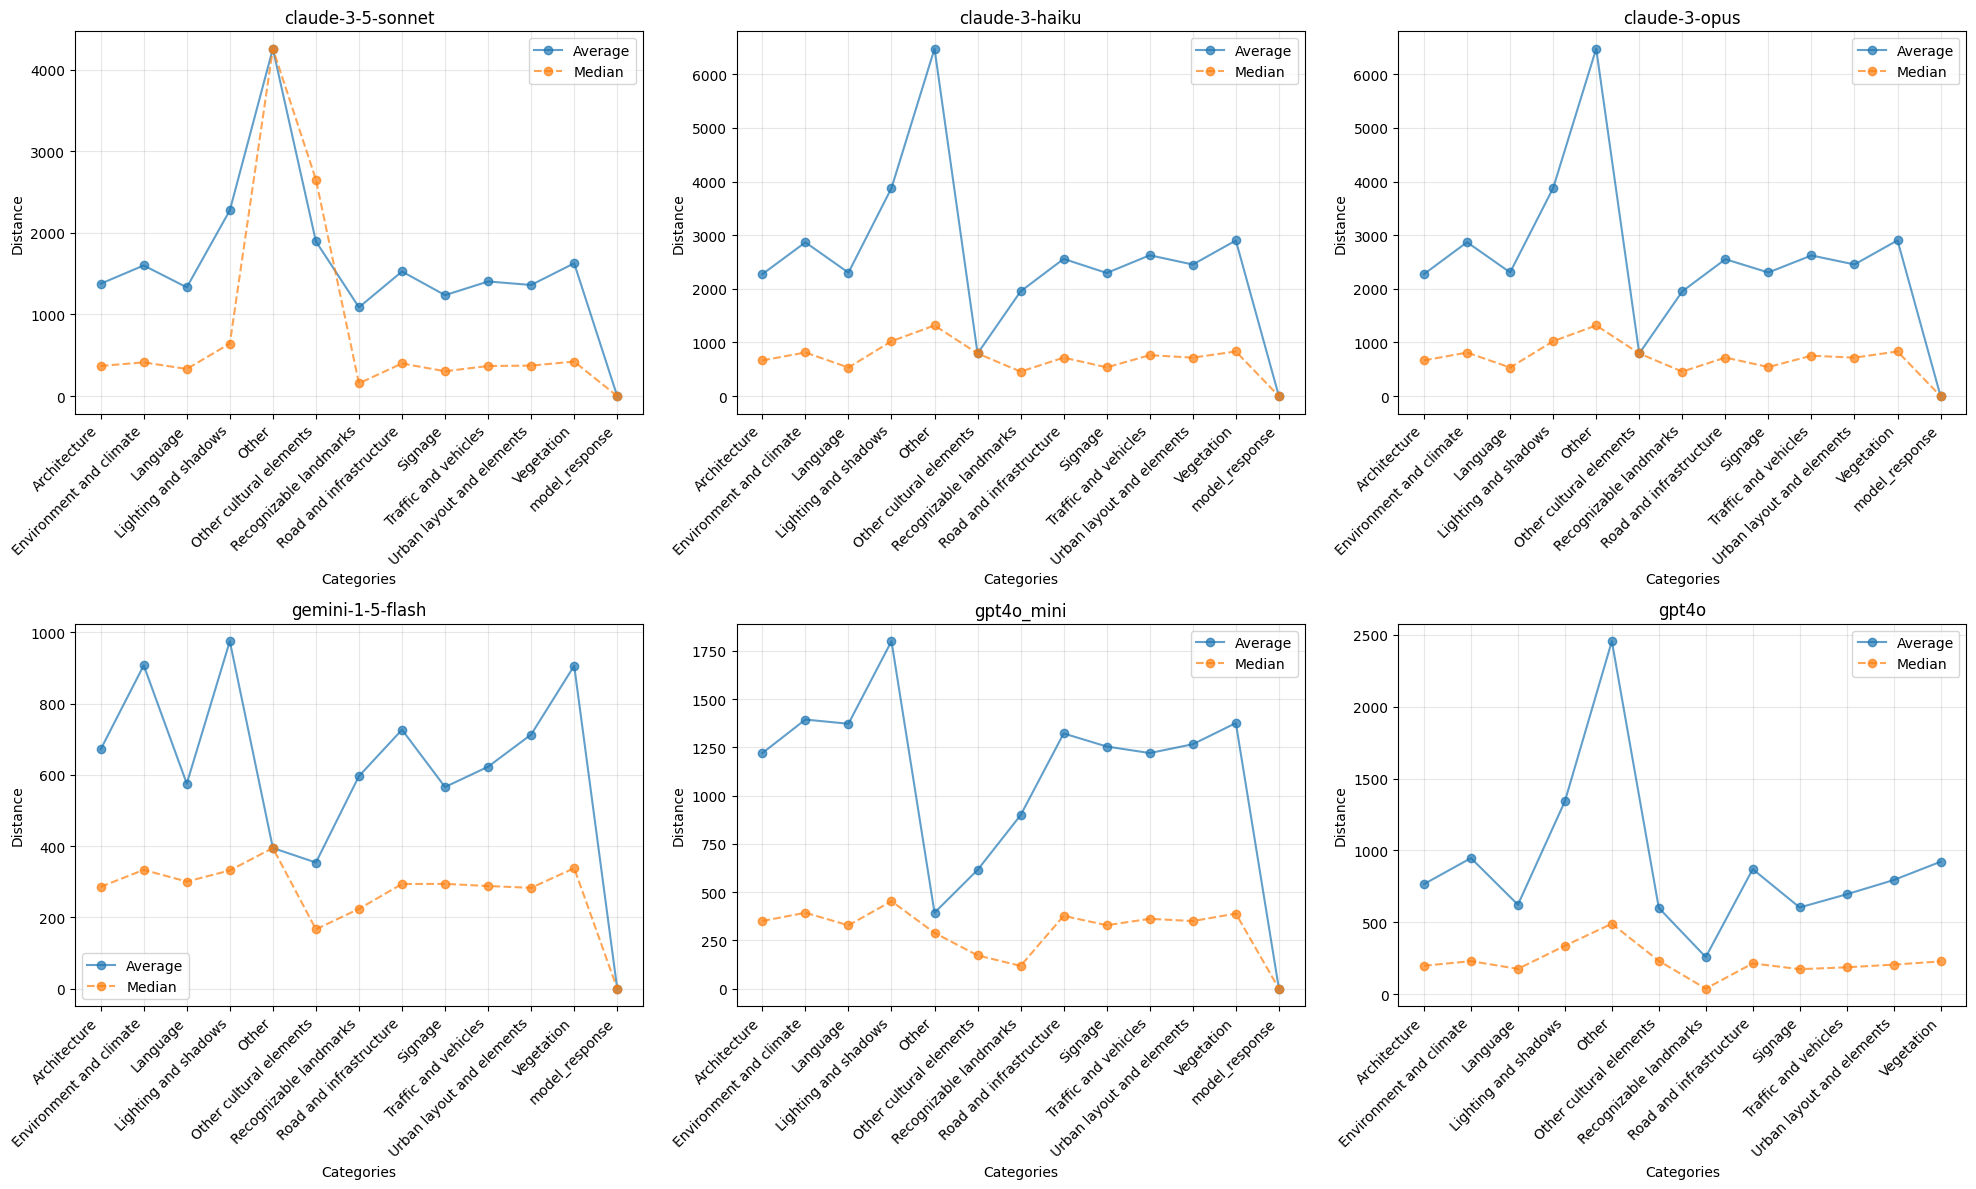


claude-3-5-sonnet Results:
Averages:
model_response: 0.0000
Road and infrastructure: 1526.6906
Urban layout and elements: 1361.4984
Signage: 1236.6284
Architecture: 1377.0123
Traffic and vehicles: 1404.1346
Vegetation: 1627.0593
Environment and climate: 1600.5595
Lighting and shadows: 2275.1847
Recognizable landmarks: 1087.8029
Language: 1332.4128
Other cultural elements: 1895.3482
Other: 4255.2111

Medians:
model_response: 0.0000
Road and infrastructure: 399.9059
Urban layout and elements: 373.8475
Signage: 304.7647
Architecture: 369.5129
Traffic and vehicles: 369.0955
Vegetation: 423.1455
Environment and climate: 413.4960
Lighting and shadows: 643.3456
Recognizable landmarks: 156.9461
Language: 332.9282
Other cultural elements: 2652.0926
Other: 4255.2111

claude-3-haiku Results:
Averages:
model_response: 0.0000
Road and infrastructure: 2558.6842
Urban layout and elements: 2453.8669
Signage: 2296.1916
Architecture: 2274.2712
Traffic and vehicles: 2626.3630
Vegetation: 2901.7539
Envir

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# List of model names and their corresponding files


# Dictionary to store results for all models
all_results = {}

for model in models:
    filename = f'{model}_categories_final.csv'

    # Load the DataFrame
    merged_df = pd.read_csv(filename)

    # Calculate averages and medians
    exclude_cols = ['image_name', 'distance', 'raw']
    average_distances = {}
    median_distances = {}

    for col in merged_df.columns:
        if col not in exclude_cols:
            distances = merged_df.loc[merged_df[col] == 1, 'distance']
            if not distances.empty:
                average_distances[col] = distances.mean()
                median_distances[col] = distances.median()
            else:
                average_distances[col] = 0
                median_distances[col] = 0

    all_results[model] = {
        'avg': average_distances,
        'median': median_distances
    }

import pandas as pd
import matplotlib.pyplot as plt

# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

# Plot settings
marker = 'o'
colors = ['#1f77b4', '#ff7f0e']  # Blue for average, orange for median

# Create subplot for each model
for idx, (model, results) in enumerate(all_results.items()):
    # Get categories and values for this model
    categories = sorted(list(results['avg'].keys()))
    avg_distances = [results['avg'][cat] for cat in categories]
    median_distances = [results['median'][cat] for cat in categories]

    x = range(len(categories))

    # Plot average with solid line
    axs[idx].plot(x, avg_distances,
                  label='Average',
                  marker=marker,
                  color=colors[0],
                  linestyle='-',
                  alpha=0.7)

    # Plot median with dashed line
    axs[idx].plot(x, median_distances,
                  label='Median',
                  marker=marker,
                  color=colors[1],
                  linestyle='--',
                  alpha=0.7)

    # Customize each subplot
    axs[idx].set_xlabel('Categories')
    axs[idx].set_ylabel('Distance')
    axs[idx].set_title(f'{model}')
    axs[idx].set_xticks(range(len(categories)))
    axs[idx].set_xticklabels(categories, rotation=45, ha='right')
    axs[idx].grid(True, alpha=0.3)
    axs[idx].legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Print numerical results
for model in models:
    print(f"\n{model} Results:")
    print("Averages:")
    for cat, avg in all_results[model]['avg'].items():
        print(f"{cat}: {avg:.4f}")
    print("\nMedians:")
    for cat, med in all_results[model]['median'].items():
        print(f"{cat}: {med:.4f}")


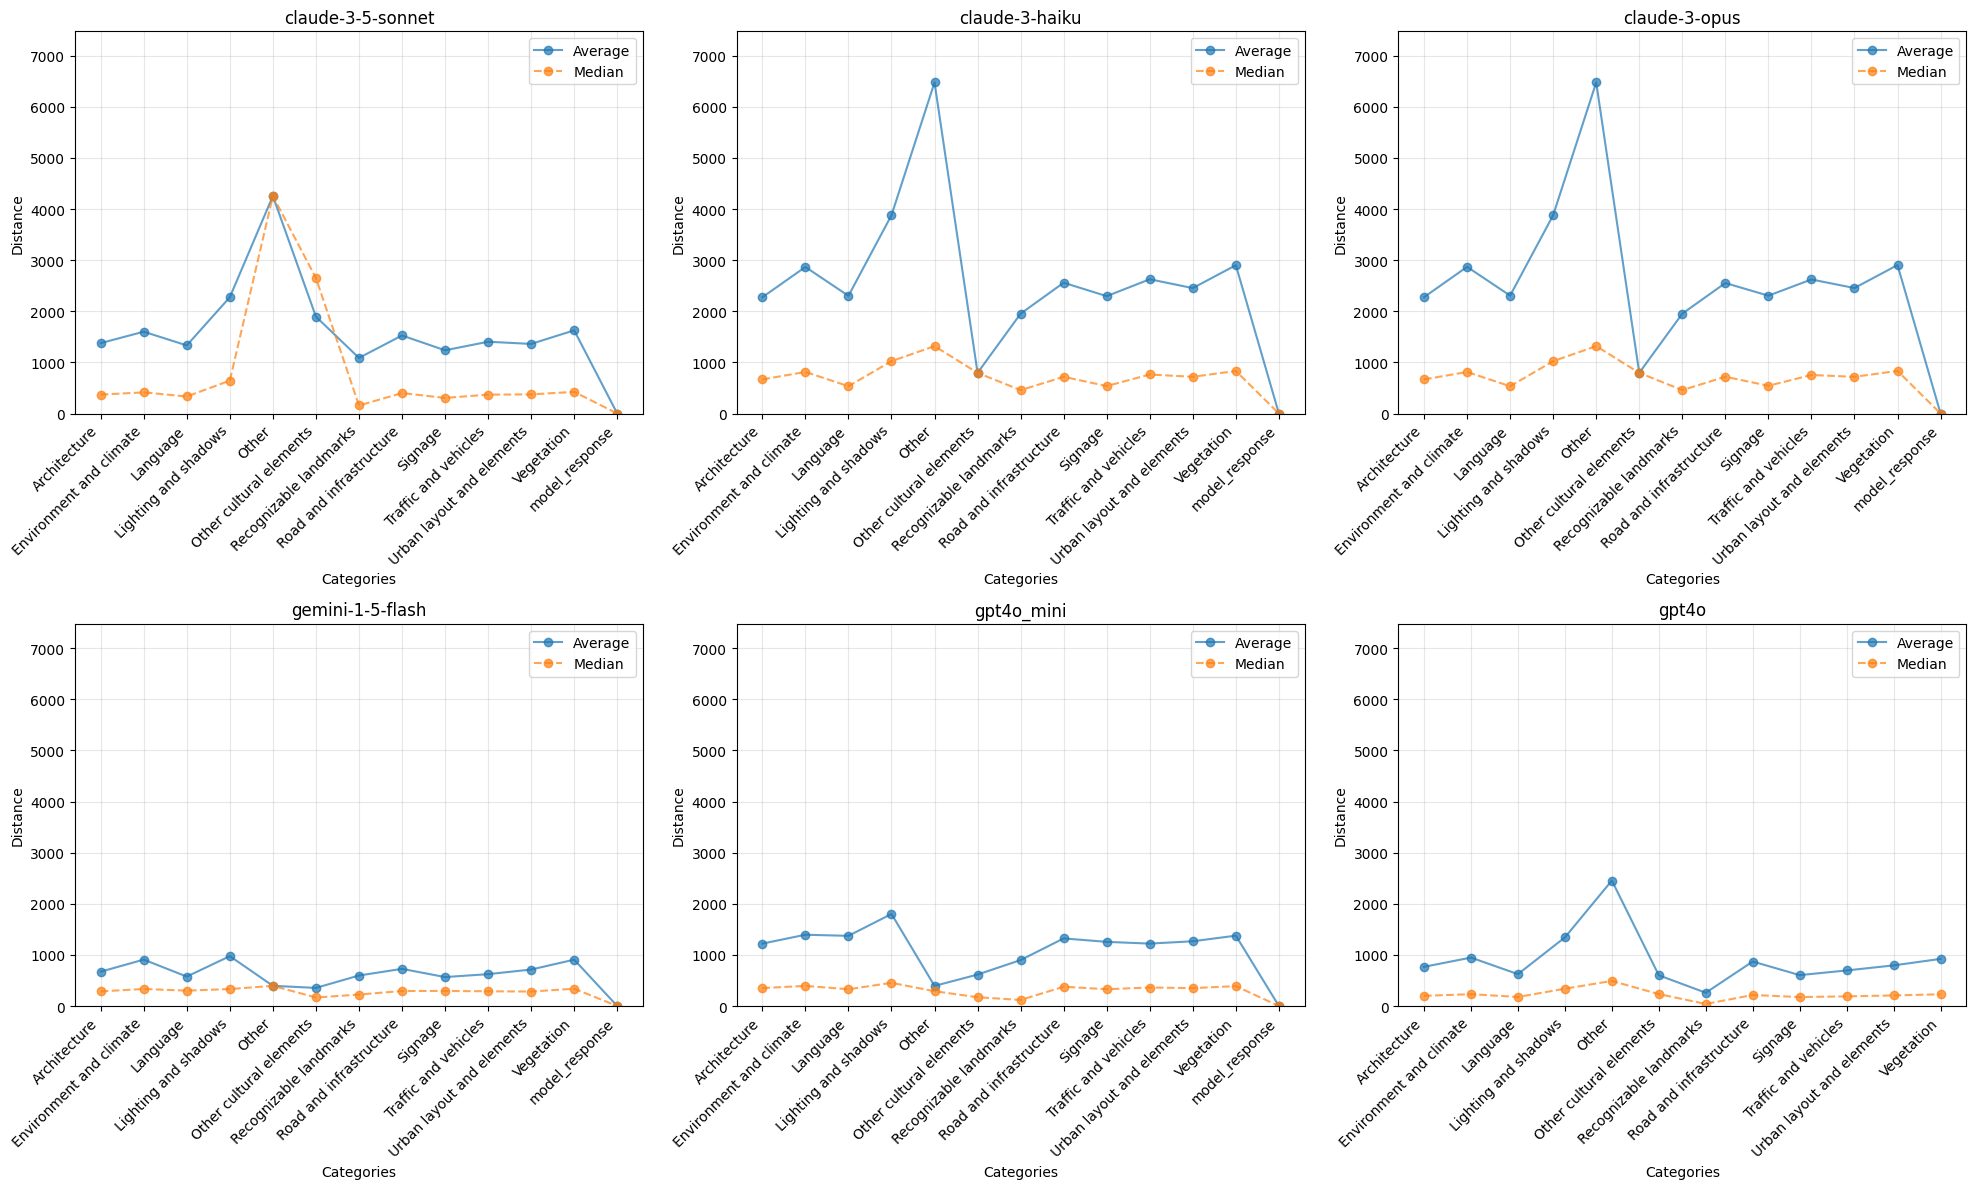

In [ ]:
# prompt: set yrange for all subplots be the same and yscale be log

# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.ravel()  # Flatten the 2D array of axes for easier indexing

# Plot settings
marker = 'o'
colors = ['#1f77b4', '#ff7f0e']  # Blue for average, orange for median

# Find the maximum y-value across all models
max_y = 0
for model, results in all_results.items():
    max_y = max(max_y, max(results['avg'].values()))
    max_y = max(max_y, max(results['median'].values()))

# Create subplot for each model
for idx, (model, results) in enumerate(all_results.items()):
    # Get categories and values for this model
    categories = sorted(list(results['avg'].keys()))
    avg_distances = [results['avg'][cat] for cat in categories]
    median_distances = [results['median'][cat] for cat in categories]

    x = range(len(categories))

    # Plot average with solid line
    axs[idx].plot(x, avg_distances,
                  label='Average',
                  marker=marker,
                  color=colors[0],
                  linestyle='-',
                  alpha=0.7)

    # Plot median with dashed line
    axs[idx].plot(x, median_distances,
                  label='Median',
                  marker=marker,
                  color=colors[1],
                  linestyle='--',
                  alpha=0.7)

    # Customize each subplot
    axs[idx].set_xlabel('Categories')
    axs[idx].set_ylabel('Distance')
    axs[idx].set_title(f'{model}')
    axs[idx].set_xticks(range(len(categories)))
    axs[idx].set_xticklabels(categories, rotation=45, ha='right')
    axs[idx].grid(True, alpha=0.3)
    axs[idx].legend()

    #Set y-axis scale to logarithmic
   # axs[idx].set_yscale('log')
    #Set y-axis limits to be the same for all subplots
  #  axs[idx].set_ylim(bottom=0.1, top = max_y + 1)

    axs[idx].set_ylim(bottom=0, top = max_y + 1000)


# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
merged_df.to_csv('gpt4o_categories_final.csv', index=False)

In [ ]:
merged_df.head()

image_name     distance  Road and infrastructure  \
0  imgs_final_v1/0.jpg    65.499125                        1   
1  imgs_final_v1/1.jpg  5209.772014                        1   
2  imgs_final_v1/2.jpg   417.973338                        1   
3  imgs_final_v1/3.jpg     0.097043                        1   
4  imgs_final_v1/4.jpg     2.798213                        1   

   Urban layout and elements  Signage  Architecture  Traffic and vehicles  \
0                          1        0             1                     1   
1                          1        0             1                     1   
2                          1        1             1                     1   
3                          1        1             1                     1   
4                          1        1             1                     1   

   Vegetation  Environment and climate  Lighting and shadows  \
0           1                        1                     0   
1           1                        1                     0   
2           1                        1                     0   
3           1                        1                     0   
4           1                        1                     0   

   Recognizable landmarks  Language  Other cultural elements  Other  \
0                       0         0                        0      0   
1                       0         0                        0      0   
2                       0         1                        0      0   
3                       0         1                        0      0   
4                       0         1                        0      0   

                                                 raw  
0  {\n  "Road and infrastructure": 1,\n  "Urban l...  
1  {\n  "Road and infrastructure": 1,\n  "Urban l...  
2  {\n  "Road and infrastructure": 1,\n  "Urban l...  
3  {\n  "Road and infrastructure": 1,\n  "Urban l...  
4  {\n  "Road and infrastructure": 1,\n  "Urban l...

In [ ]:
# prompt: for each column except for image_name, distance, and raw, get all rows that have 1, get the 'distance' from that row and add them all up. after that, get the average distance.

import pandas as pd

# Load the merged DataFrame
merged_df = pd.read_csv('gpt4o_categories_final.csv')

# Columns to exclude from the analysis
exclude_cols = ['image_name', 'distance', 'raw']

# Initialize an empty dictionary to store the average distances
average_distances = {}

# Iterate through the columns
for col in merged_df.columns:
    if col not in exclude_cols:
        # Get the rows where the current column's value is 1
        rows_with_one = merged_df[merged_df[col] == 1]

        # Extract the distances from these rows
        distances = rows_with_one['distance']

        # Calculate the sum of distances and the average distance
        if not distances.empty:
            sum_distances = distances.sum()
            average_distance = sum_distances / len(distances)
            average_distances[col] = average_distance
        else:
            average_distances[col] = 0  # Set average to 0 if no rows have 1


# Print the average distances
for category, avg_distance in average_distances.items():
    print(f"Average distance for {category}: {avg_distance}")


# prompt: also get the median

import pandas as pd

# Assuming your data is in a DataFrame called 'merged_df'
# Replace 'merged_df' with the actual name of your DataFrame if different
merged_df = pd.read_csv('gpt4o_categories_final.csv')

# Calculate the median distance for each category where the value is 1
median_distances = {}
exclude_cols = ['image_name', 'distance', 'raw']
for col in merged_df.columns:
    if col not in exclude_cols:
        distances = merged_df.loc[merged_df[col] == 1, 'distance']
        if not distances.empty:
          median_distances[col] = distances.median()
        else:
          median_distances[col] = 0

# Print the median distances
for category, median_distance in median_distances.items():
    print(f"Median distance for {category}: {median_distance}")

Average distance for Road and infrastructure: 863.1121302058848
Average distance for Urban layout and elements: 788.2244902742568
Average distance for Signage: 601.2469897084458
Average distance for Architecture: 760.9980427475657
Average distance for Traffic and vehicles: 691.0318292643733
Average distance for Vegetation: 914.9601367227667
Average distance for Environment and climate: 939.5330221595958
Average distance for Lighting and shadows: 1322.2423557024426
Average distance for Recognizable landmarks: 256.73773034478654
Average distance for Language: 620.5462832091673
Average distance for Other cultural elements: 586.8255215416884
Average distance for Other: 2454.4723088249893
Median distance for Road and infrastructure: 215.39860149968558
Median distance for Urban layout and elements: 206.82236527577487
Median distance for Signage: 175.30497241963016
Median distance for Architecture: 199.0358374888477
Median distance for Traffic and vehicles: 188.21222397622373
Median distance 

In [ ]:
average_distances

{'Road and infrastructure': 100,
 'Urban layout and elements': 150,
 'Signage': 50}

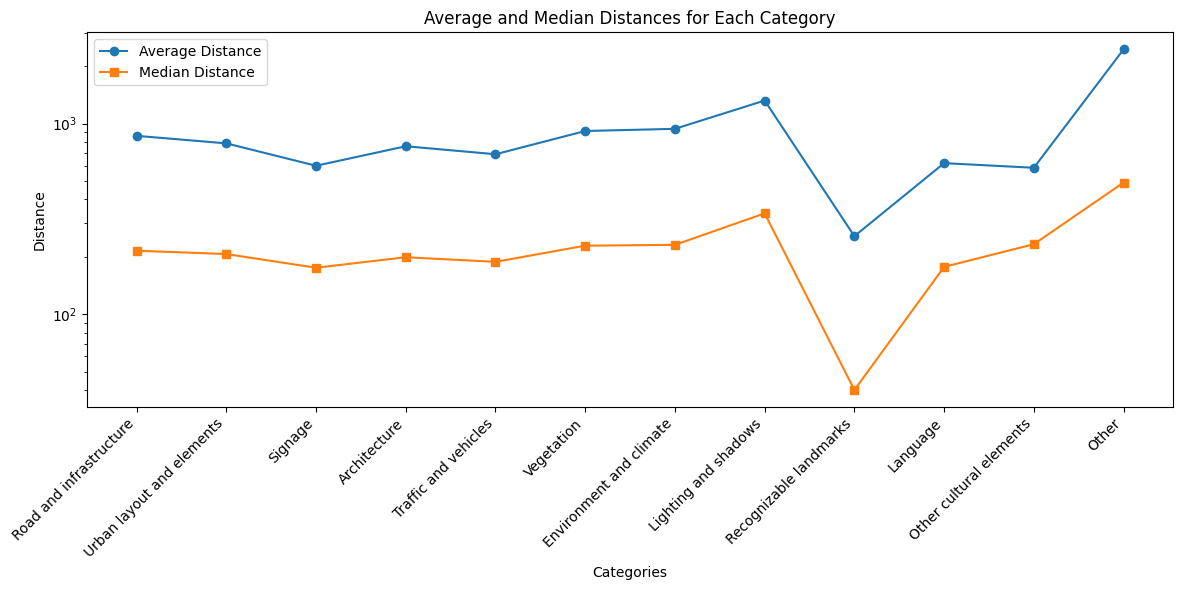

In [ ]:
# prompt: copy code from the above and then plot them

import matplotlib.pyplot as plt

# Assuming 'average_distances' and 'median_distances' dictionaries are already populated
# as in the previous code.

categories = list(average_distances.keys())
avg_distances = list(average_distances.values())
median_distances = list(median_distances.values())

x = range(len(categories))

plt.figure(figsize=(12, 6))
plt.plot(x, avg_distances, label='Average Distance', marker='o')
plt.plot(x, median_distances, label='Median Distance', marker='s')

plt.xlabel('Categories')
plt.ylabel('Distance')
plt.yscale('log')
plt.title('Average and Median Distances for Each Category')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

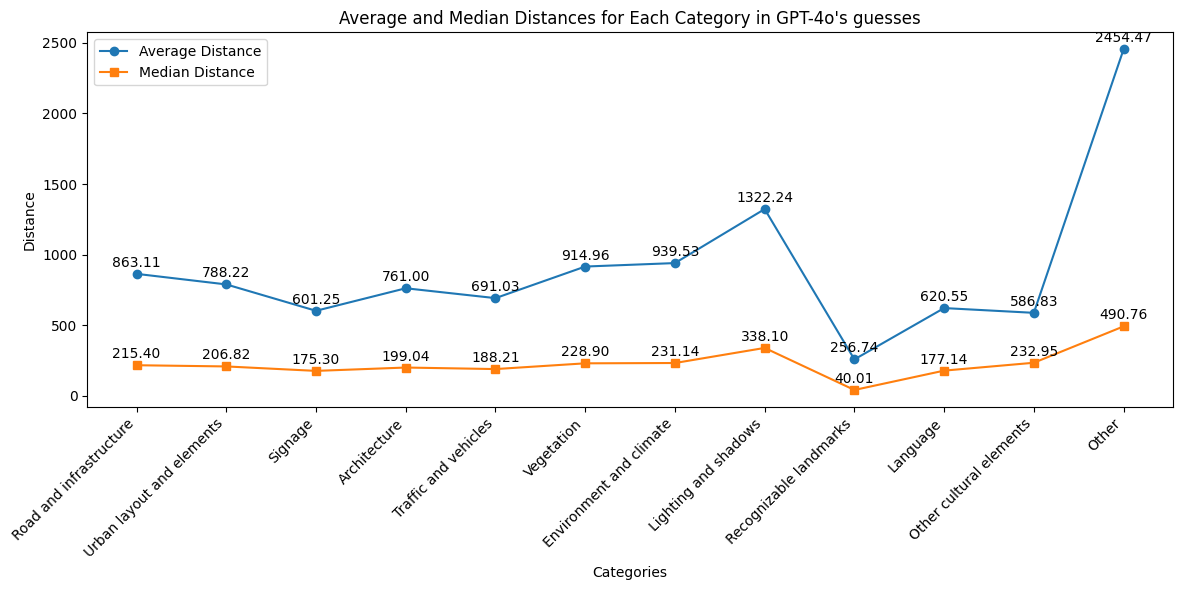

In [ ]:
# prompt: plot the value above the dots

import matplotlib.pyplot as plt

# Assuming 'average_distances' and 'median_distances' dictionaries are already populated
# as in the previous code.

categories = list(average_distances.keys())
avg_distances = list(average_distances.values())
median_distances = list(median_distances.values())

x = range(len(categories))

plt.figure(figsize=(12, 6))
plt.plot(x, avg_distances, label='Average Distance', marker='o')
plt.plot(x, median_distances, label='Median Distance', marker='s')

# Add value labels above the dots
for i, txt in enumerate(avg_distances):
    plt.annotate(f"{txt:.2f}", (x[i], avg_distances[i]), textcoords="offset points", xytext=(0,5), ha='center')
for i, txt in enumerate(median_distances):
    plt.annotate(f"{txt:.2f}", (x[i], median_distances[i]), textcoords="offset points", xytext=(0,5), ha='center')

plt.xlabel('Categories')
plt.ylabel('Distance')
plt.title('Average and Median Distances for Each Category in GPT-4o\'s guesses')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# prompt: print 5 rows where distance is smallest, that also has recognisable landmarks

import pandas as pd

# Load the merged DataFrame
merged_df = pd.read_csv('gpt4o_categories_final.csv')

# Sort the DataFrame by distance in ascending order
sorted_df = merged_df.sort_values(by='distance')

# Filter for rows where 'Recognizable landmarks' is 1
landmark_df = sorted_df[sorted_df['Recognizable landmarks'] == 1]

# Print the first 5 rows
print(landmark_df.head(5))

                  image_name  distance  Road and infrastructure  \
1445  imgs_final_v1/1445.jpg  0.015168                        1   
653    imgs_final_v1/653.jpg  0.036212                        1   
865    imgs_final_v1/865.jpg  0.037063                        1   
844    imgs_final_v1/844.jpg  0.041584                        1   
871    imgs_final_v1/871.jpg  0.046312                        1   

      Urban layout and elements  Signage  Architecture  Traffic and vehicles  \
1445                          1        0             1                     0   
653                           1        1             1                     1   
865                           1        1             1                     1   
844                           1        1             1                     1   
871                           1        1             1                     1   

      Vegetation  Environment and climate  Lighting and shadows  \
1445           1                        1        

In [ ]:
len(gpt4o_df)

1602

In [ ]:
# prompt: print number of rows in gpt4o df that has distance less than 0.1, 1, 10, 100, 1000, 10000, 100000 and nans

import pandas as pd

# Load the merged DataFrame
merged_df = pd.read_csv('gpt4o_categories_final.csv')

# Define distance thresholds
thresholds = [0.1, 1, 10, 100, 1000, 10000, 100000]

# Print the number of rows for each threshold and NaNs
for threshold in thresholds:
    count = len(merged_df[merged_df['distance'] < threshold])
    print(f"Number of rows with distance < {threshold}: {count}")

nan_count = merged_df['distance'].isna().sum()
print(f"Number of rows with NaN distance: {nan_count}")

Number of rows with distance < 0.1: 26
Number of rows with distance < 1: 153
Number of rows with distance < 10: 265
Number of rows with distance < 100: 591
Number of rows with distance < 1000: 1304
Number of rows with distance < 10000: 1550
Number of rows with distance < 100000: 1578
Number of rows with NaN distance: 24


In [ ]:
gpt4o_df['model_response'][472]

"I'm unable to determine the exact location from the image provided. However, I can offer some general observations:\n\n1. **Parking Lot**: The image shows a large parking lot with a variety of vehicles, suggesting a location near a shopping center, stadium, or large public venue.\n\n2. **Vegetation and Climate**: The trees and greenery indicate a temperate climate, possibly in North America or Europe.\n\n3. **Lighting and Infrastructure**: The tall light poles are typical of large parking areas, often found in suburban or urban settings.\n\n4. **Vehicles**: The mix of cars and trucks, including some American models, might suggest a location in the United States.\n\nWithout more specific landmarks or signage, it's challenging to pinpoint the exact location. If you have additional images or context, that could help narrow it down further."

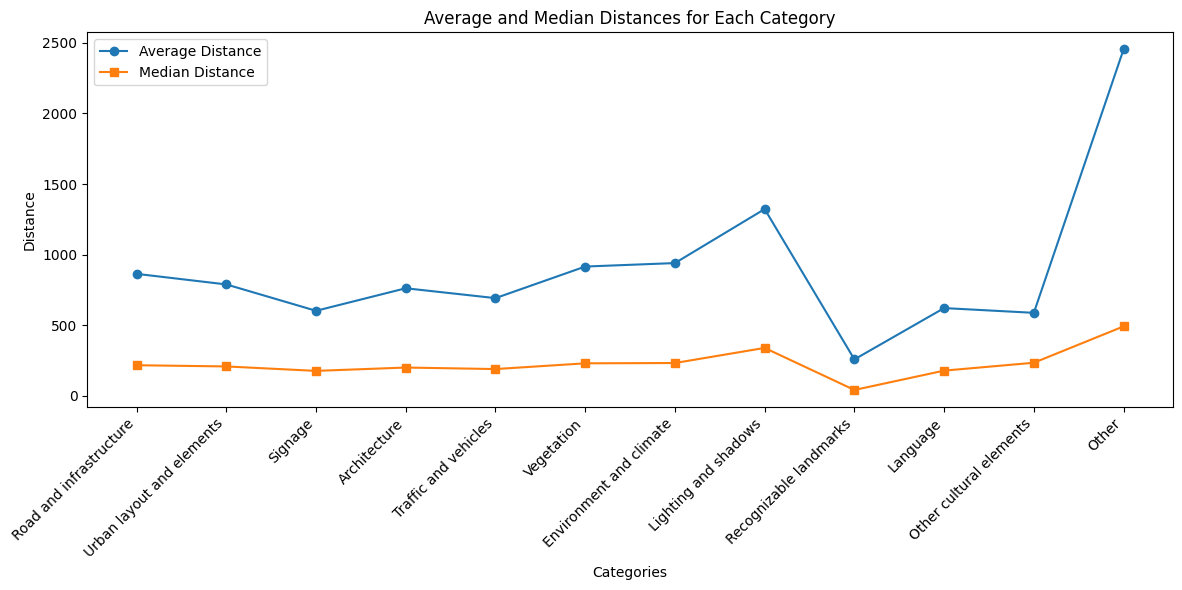

In [ ]:
# prompt: copy code from the above and then plot them

import matplotlib.pyplot as plt

# Assuming 'average_distances' and 'median_distances' dictionaries are already populated
# as in the previous code.

categories = list(average_distances.keys())
avg_distances = list(average_distances.values())
median_distances = list(median_distances.values())

x = range(len(categories))

plt.figure(figsize=(12, 6))
plt.plot(x, avg_distances, label='Average Distance', marker='o')
plt.plot(x, median_distances, label='Median Distance', marker='s')

plt.xlabel('Categories')
plt.ylabel('Distance')
plt.yscale('log')
plt.title('Average and Median Distances for Each Category')
plt.xticks(x, categories, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
for i in range(len(all_labels_reasonings)):
  print(str(i) + " " + str(all_labels_reasonings[i]))

0 {
  "Road and infrastructure": 1,
  "Urban layout and elements": 1,
  "Signage": 0,
  "Architecture": 1,
  "Traffic and vehicles": 1,
  "Vegetation": 1,
  "Environment and climate": 1,
  "Lighting and shadows": 0,
  "Recognizable landmarks": 0,
  "Language": 0,
  "Other cultural elements": 0,
  "Other": 0
}
1 {
  "Road and infrastructure": 1,
  "Urban layout and elements": 1,
  "Signage": 0,
  "Architecture": 1,
  "Traffic and vehicles": 1,
  "Vegetation": 1,
  "Environment and climate": 1,
  "Lighting and shadows": 0,
  "Recognizable landmarks": 0,
  "Language": 0,
  "Other cultural elements": 0,
  "Other": 0
}
2 {
  "Road and infrastructure": 1,
  "Urban layout and elements": 1,
  "Signage": 0,
  "Architecture": 1,
  "Traffic and vehicles": 1,
  "Vegetation": 1,
  "Environment and climate": 1,
  "Lighting and shadows": 0,
  "Recognizable landmarks": 0,
  "Language": 0,
  "Other cultural elements": 0,
  "Other": 0
}
3 {
  "Road and infrastructure": 1,
  "Urban layout and elements": 

In [ ]:
# prompt: concat category_lists['Road and infrastructure'] to road_and_infrastructure

road_and_infrastructure = road_and_infrastructure.tolist() + category_lists['Road and infrastructure']

In [ ]:
urban_layout_and_elements = urban_layout_and_elements.tolist() + category_lists['Urban layout and elements']
signage = signage.tolist() + category_lists['Signage']
architecture = architecture.tolist() + category_lists['Architecture']
traffic_and_vehicles = traffic_and_vehicles.tolist() + category_lists['Traffic and vehicles']
vegetation = vegetation.tolist() + category_lists['Vegetation']
environment_and_climate = environment_and_climate.tolist() + category_lists['Environment and climate']
lighting_and_shadows = lighting_and_shadows.tolist() + category_lists['Lighting and shadows']
recognizable_landmarks = recognizable_landmarks.tolist() + category_lists['Recognizable landmarks']
language = language.tolist() + category_lists['Language']
other_cultural_elements = other_cultural_elements.tolist() + category_lists['Other cultural elements']
other = other.tolist() + category_lists['Other']
reasoning = reasoning.tolist() + all_labels_reasonings

In [ ]:
df = pd.DataFrame()
df['Road and infrastructure'] = road_and_infrastructure
df['Urban layout and elements'] = urban_layout_and_elements
df['Signage'] = signage
df['Architecture'] = architecture
df['Traffic and vehicles'] = traffic_and_vehicles
df['Vegetation'] = vegetation
df['Environment and climate'] = environment_and_climate
df['Lighting and shadows'] = lighting_and_shadows
df['Recognizable landmarks'] = recognizable_landmarks
df['Language'] = language
df['Other cultural elements'] = other_cultural_elements
df['Other'] = other
#df['Reasoning'] = reasoning
df.head()

Road and infrastructure  Urban layout and elements  Signage  Architecture  \
0                        1                          1        0             1   
1                        1                          1        1             0   
2                        1                          1        1             1   
3                        1                          1        1             1   
4                        1                          1        1             1   

   Traffic and vehicles  Vegetation  Environment and climate  \
0                     1           1                        1   
1                     0           1                        1   
2                     1           0                        1   
3                     1           1                        1   
4                     1           1                        1   

   Lighting and shadows  Recognizable landmarks  Language  \
0                     0                       0         0   
1                     0                       0         1   
2                     1                       0         1   
3                     0                       0         1   
4                     0                       1         1   

   Other cultural elements  Other  
0                        0      0  
1                        0      0  
2                        0      0  
3                        0      0  
4                        0      0

In [ ]:
len(df)

799

In [ ]:
df.to_csv('gpt4o_labels.csv', index=False)